# Kiva Data Preparation and Exploring

## Data Preparation

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file = os.path.join('resource', f'kiva_loans.csv')
df = pd.read_csv(file)

original_columns = df.columns
original_columns

Index(['id', 'funded_amount', 'loan_amount', 'activity', 'sector', 'use',
       'country_code', 'country', 'region', 'currency', 'partner_id',
       'posted_time', 'disbursed_time', 'funded_time', 'term_in_months',
       'lender_count', 'tags', 'borrower_genders', 'repayment_interval',
       'date'],
      dtype='object')

In [3]:
df.dtypes

id                      int64
funded_amount         float64
loan_amount           float64
activity               object
sector                 object
use                    object
country_code           object
country                object
region                 object
currency               object
partner_id            float64
posted_time            object
disbursed_time         object
funded_time            object
term_in_months        float64
lender_count            int64
tags                   object
borrower_genders       object
repayment_interval     object
date                   object
dtype: object

In [4]:
df.head(2)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01


In [5]:
df.count()

id                    671205
funded_amount         671205
loan_amount           671205
activity              671205
sector                671205
use                   666977
country_code          671197
country               671205
region                614405
currency              671205
partner_id            657698
posted_time           671205
disbursed_time        668809
funded_time           622874
term_in_months        671205
lender_count          671205
tags                  499789
borrower_genders      666984
repayment_interval    671205
date                  671205
dtype: int64

## Convert the date to timestamp

In [6]:
time_columns = ['posted_time', 'disbursed_time', 'funded_time', 'date']
df.loc[:, time_columns] = df[time_columns].apply(pd.to_datetime)

## Clean Up Gender
The source data list multiple genders in borrow_genders field. To simplify the analysis, a gender field is added base on majority of gender in genders.

In [7]:
df.borrower_genders.value_counts()

female                                                                                                                                                                                                                                426502
male                                                                                                                                                                                                                                  134710
female, female                                                                                                                                                                                                                         12164
female, female, female                                                                                                                                                                                                                 11676
female, female, female, female                      

In [8]:
from collections import Counter
def normalize_gender(borrower_genders):
    if isinstance(borrower_genders, str):
        return Counter(
            map(
                lambda x: x.replace(' ', ''),
                borrower_genders.split(', ')
            )
        ).most_common(1)[0][0]
    else:
        return borrower_genders
df.loc[:, 'gender'] = df['borrower_genders'].apply(normalize_gender)

df.gender.value_counts()

female    517592
male      149392
Name: gender, dtype: int64

### Take a Sample for Development

In [9]:
df[original_columns].sample(1000).to_csv(
    os.path.join('resource', 'kiva_loans_sample.csv'),
    encoding='utf-8'
)

### GDP Data (Word Bank)

In [26]:
import wbdata
gdp_list = []
for country_code in df.country_code.unique():
    if isinstance(country_code, str):
        gdp_list.append([country_code, wbdata.get_data("NY.GDP.PCAP.CD", country=(country_code))[1]['value']] )
pd.DataFrame(gdp_list, columns=['country_code', 'gdp']).head()

,country_code,gdp
0,PK,1443.62501636392
1,IN,1709.59180811655
2,KE,1455.35976536469
3,NI,2151.38204656346
4,SV,4223.58457943469


## KivaData module
To faciliate development work, module narcos.kiva_data is been created to encapusulate the data preparation and cleanup. If use_sample=True, a 10K sample is been returned in loan_data, otherwise full data set of 670K are returned. This module also can provide other needed data such as GDP lookup data.

```python
from narcos.kiva_data import KivaData
kiva_data = KivaData(use_sample=True)
loan_data = kiva_data.loan_data
gdp = kiva_data.gdp
```


# Data Exploring

## Summary Statistics

In [20]:
amount_columns = ['funded_amount', 'loan_amount']

### Unique Value Counts

In [10]:
df.agg(lambda x: x.nunique())

id                    671205
funded_amount            610
loan_amount              479
activity                 163
sector                    15
use                   424913
country_code              86
country                   87
region                 12695
currency                  67
partner_id               366
posted_time           667399
disbursed_time          5719
funded_time           498007
term_in_months           148
lender_count             503
tags                   86719
borrower_genders       11298
repayment_interval         4
date                    1298
gender                     2
dtype: int64

From above, we see they are 15 sectors, 87 countries and 4 repayment internval. It will be use to show summarized data on those four.

### By sector

In [21]:
df.groupby('sector')[amount_columns].agg(['sum', 'median', 'count'])

funded_amount                 loan_amount               
                         sum median   count          sum median   count
sector                                                                 
Agriculture      133770635.0  500.0  180302  143067875.0  500.0  180302
Arts              11821055.0  475.0   12060   12240325.0  475.0   12060
Clothing          34805270.0  550.0   32742   37300925.0  600.0   32742
Construction       6321515.0  650.0    6268    6695150.0  700.0    6268
Education         30044920.0  700.0   31013   30968525.0  725.0   31013
Entertainment      1023095.0  650.0     830    1389150.0  887.5     830
Food             115089210.0  425.0  136657  121606150.0  450.0  136657
Health             9172250.0  650.0    9223    9843400.0  725.0    9223
Housing           21377100.0  475.0   33731   23663950.0  500.0   33731
Manufacturing      5356650.0  500.0    6208    5447900.0  500.0    6208
Personal Use      14189775.0  200.0   36385   14955350.0  200.0   36385
Retail            90864855.0  400.0  124494   98122900.0  425.0  124494
Services          42966085.0  500.0   45140   48057450.0  550.0   45140
Transportation     9842500.0  425.0   15518   11066900.0  450.0   15518
Wholesale           918900.0  925.0     634     995200.0  950.0     634

### Repayment Intervers

In [22]:
df.groupby('repayment_interval')[amount_columns].agg(['sum', 'median', 'count'])

funded_amount                 loan_amount               
                             sum median   count          sum median   count
repayment_interval                                                         
bullet                50822140.0  500.0   70728   63411775.0  575.0   70728
irregular            172992500.0  350.0  257158  177799550.0  350.0  257158
monthly              303607900.0  575.0  342717  324068550.0  600.0  342717
weekly                  141275.0  237.5     602     141275.0  237.5     602

### Quantities

In [12]:
df.describe()

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count
count,6.712050e+05,671205.000000,671205.000000,657698.000000,671205.000000,671205.000000
mean,9.932486e+05,785.995061,842.397107,178.199616,13.739022,20.590922
std,1.966113e+05,1130.398941,1198.660073,94.247581,8.598919,28.459551
min,6.530470e+05,0.000000,25.000000,9.000000,1.000000,0.000000
25%,8.230720e+05,250.000000,275.000000,126.000000,8.000000,7.000000
50%,9.927800e+05,450.000000,500.000000,145.000000,13.000000,13.000000
75%,1.163653e+06,900.000000,1000.000000,204.000000,14.000000,24.000000
max,1.340339e+06,100000.000000,100000.000000,536.000000,158.000000,2986.000000


### By Gender

In [24]:
df.groupby('gender')[amount_columns].agg(['sum', 'median', 'count'])

funded_amount                 loan_amount               
                 sum median   count          sum median   count
gender                                                         
female   399374845.0  425.0  517592  418403550.0  450.0  517592
male     124292865.0  550.0  149392  142063600.0  650.0  149392

### Date Ranges

In [14]:
df[time_columns].agg(['min', 'max'])

,posted_time,disbursed_time,funded_time,date
min,2014-01-01 04:49:26,2013-12-02 08:00:00,2014-01-01 12:18:55,2014-01-01
max,2017-07-26 06:31:46,2017-09-30 07:00:00,2017-07-26 02:09:43,2017-07-26


## Histogram

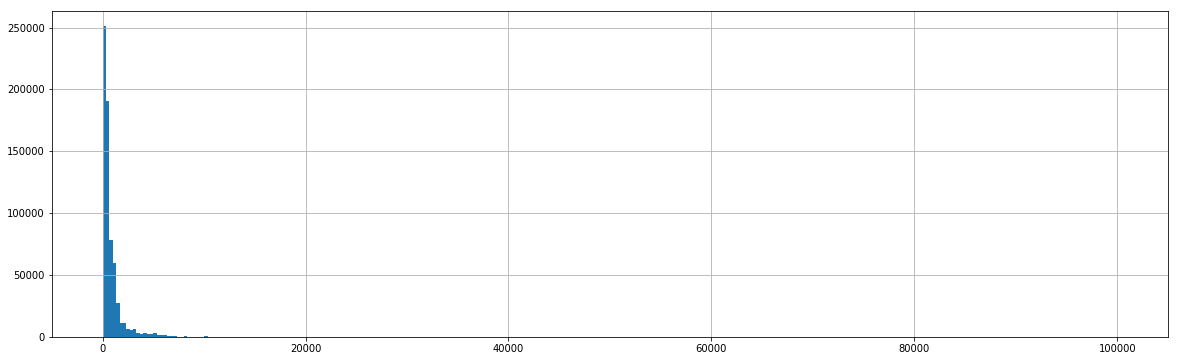

In [28]:
figure, ax = plt.subplots(figsize=(20,6))
df.reset_index()['funded_amount'].hist(
    bins=300,
    ax=ax
)
plt.show()

### Sector Comparison

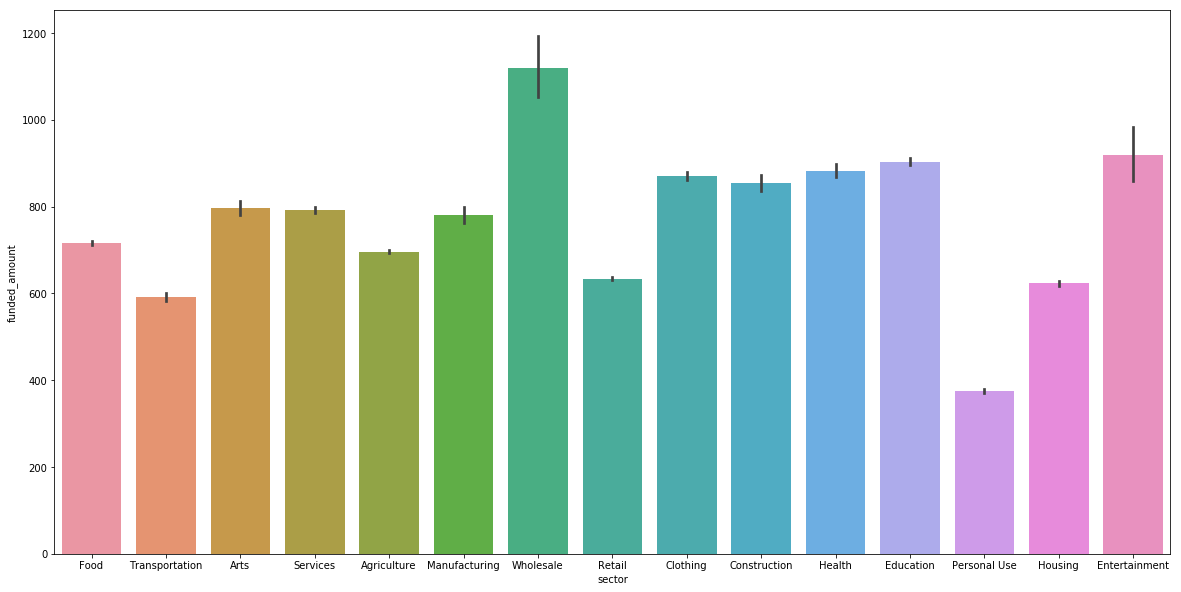

In [41]:
figure, ax = plt.subplots(figsize=(20,10))

sns.barplot(
    x='sector', 
    y='funded_amount',
    #orient="h",
    data=df[df['funded_amount'] < 5000])
plt.show()

### Load Distribution Per Sector

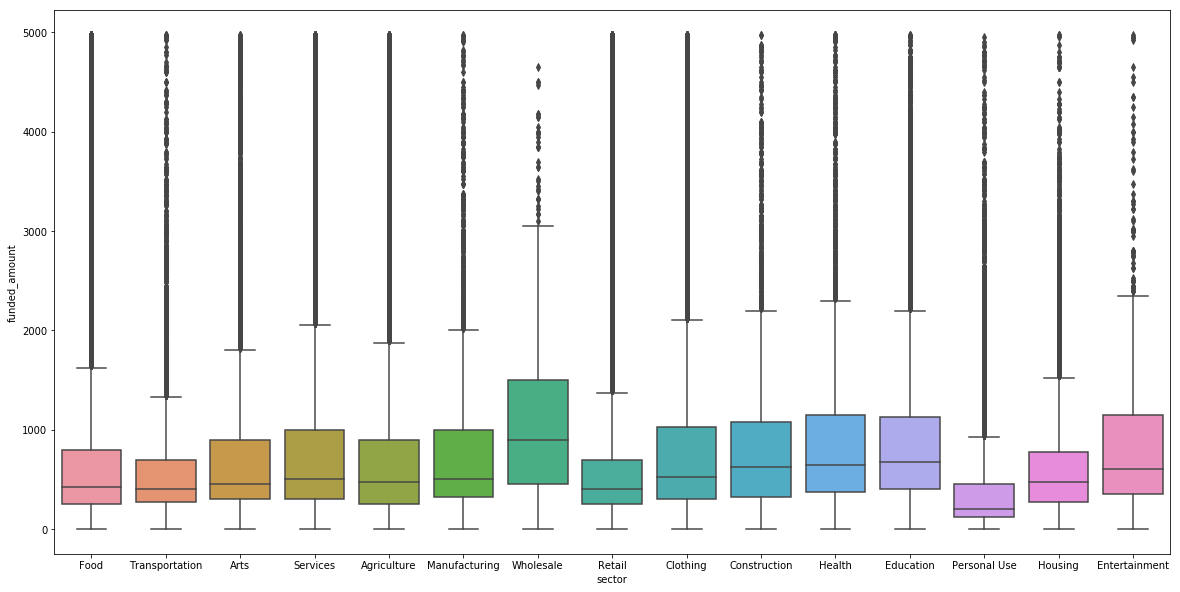

In [29]:
figure, ax = plt.subplots(figsize=(20,10))

sns.boxplot(
    x='sector', 
    y='funded_amount',
    #orient="h",
    data=df[df['funded_amount'] < 5000])
plt.show()

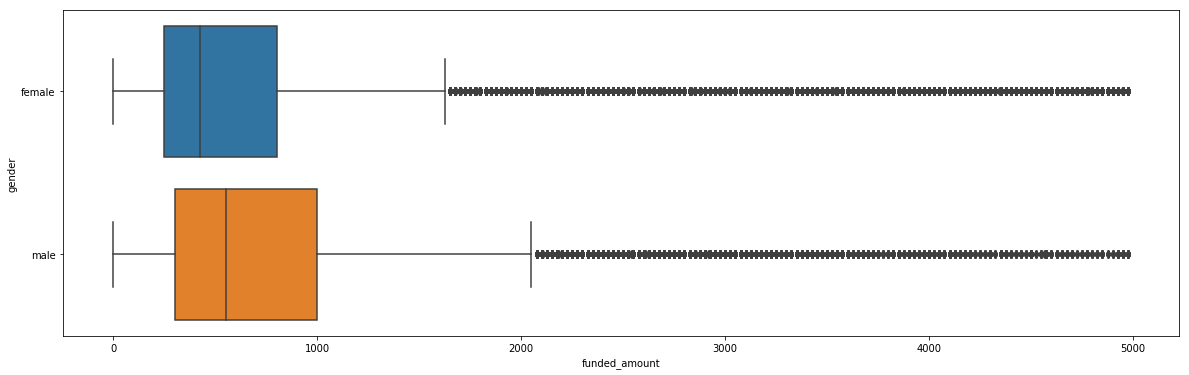

In [30]:
figure, ax = plt.subplots(figsize=(20,6))

sns.boxplot(
    y='gender', 
    x='funded_amount', 
    orient='h',
    data=df[df['funded_amount'] < 5000])
plt.show()

## Voilin Plot

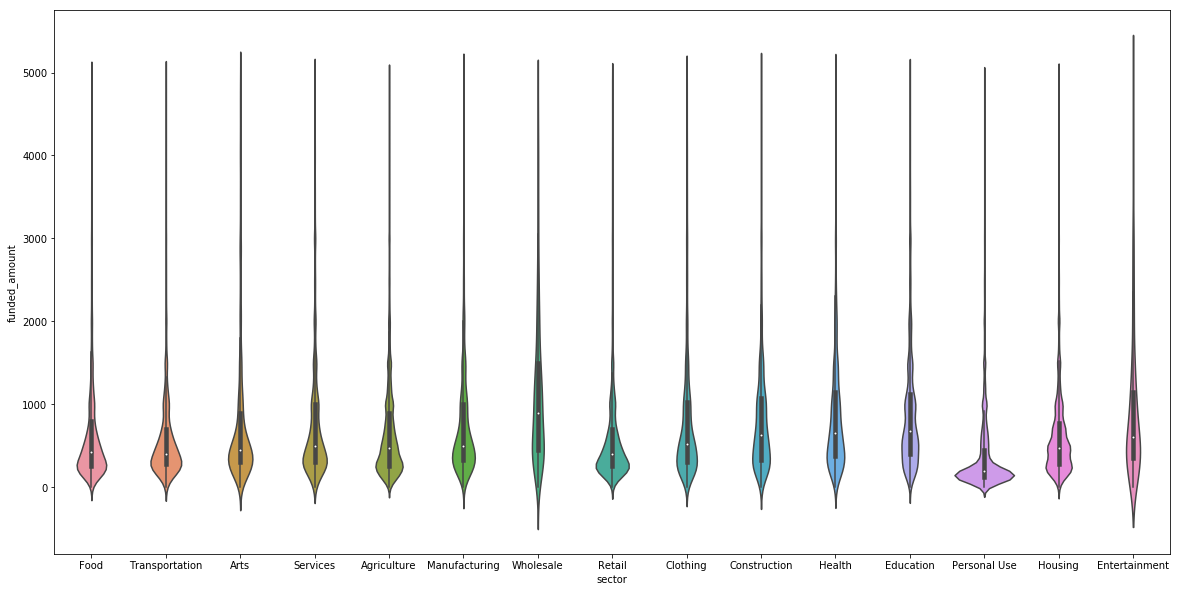

In [31]:
figure, ax = plt.subplots(figsize=(20,10))

sns.violinplot(
    x='sector',
    y='funded_amount',
    data=df[df['funded_amount'] < 5000]
)
plt.show()

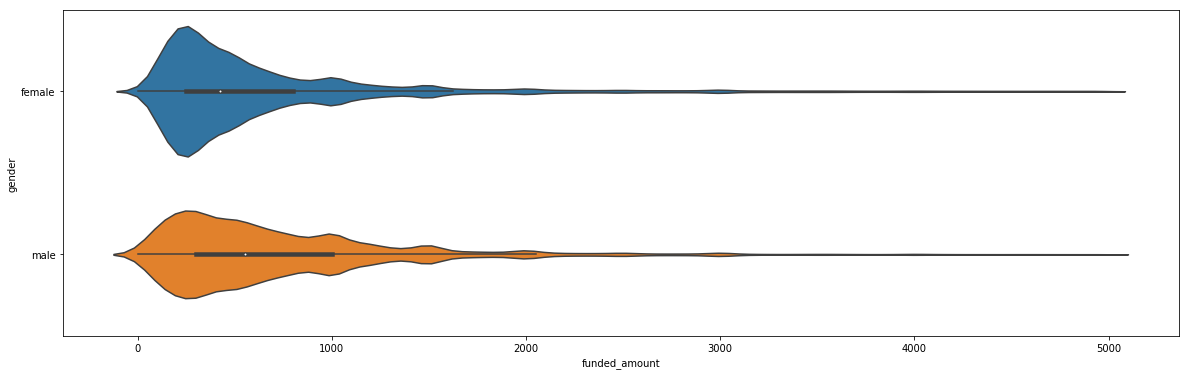

In [32]:
figure, ax = plt.subplots(figsize=(20,6))

sns.violinplot(
    y='gender', 
    x='funded_amount', 
    orient='h',
    data=df[df['funded_amount'] < 5000])
plt.show()

## Number loans ranked by country

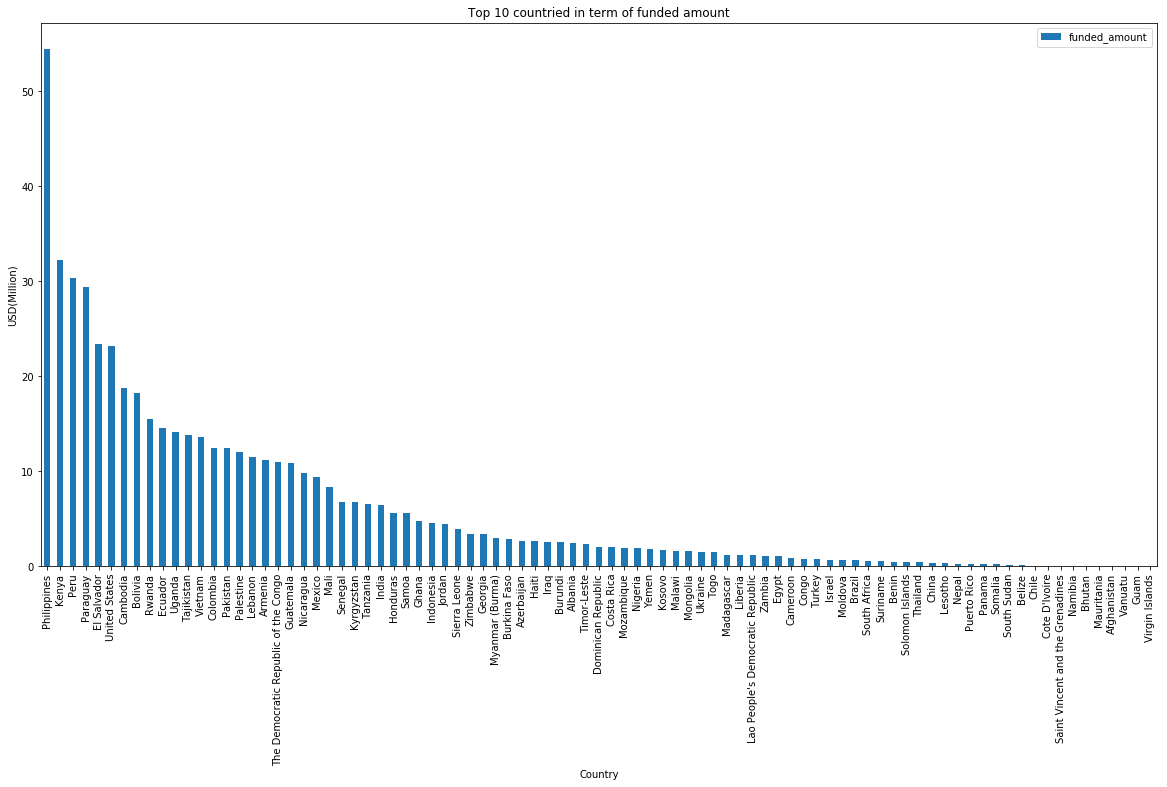

In [33]:
figure, ax = plt.subplots(figsize=(20,10))
( df.groupby('country')[['funded_amount']].sum() / (1000 * 1000 ) ).sort_values(
    by='funded_amount', ascending=False).plot.bar(
    ax=ax,
)
plt.xlabel('Country')
plt.ylabel('USD(Million)')
plt.title('Top 10 countried in term of funded amount')
plt.show()

In [34]:
(df.groupby(
       ['country', 'gender']
    )[['funded_amount']].sum() / (1000 * 1000 )).sort_values(
        by='funded_amount', ascending=False).head(10).reset_index()

,country,gender,funded_amount
0,Philippines,female,50.944325
1,Paraguay,female,27.395350
2,Peru,female,23.518925
3,Kenya,female,22.950025
4,Cambodia,female,16.414300
5,Bolivia,female,15.513800
6,El Salvador,female,13.868200
7,United States,female,13.193775
8,Vietnam,female,13.168900
9,Rwanda,female,12.129550


## Stacked Bar showing How Loan Distributed Amount Genders per Country

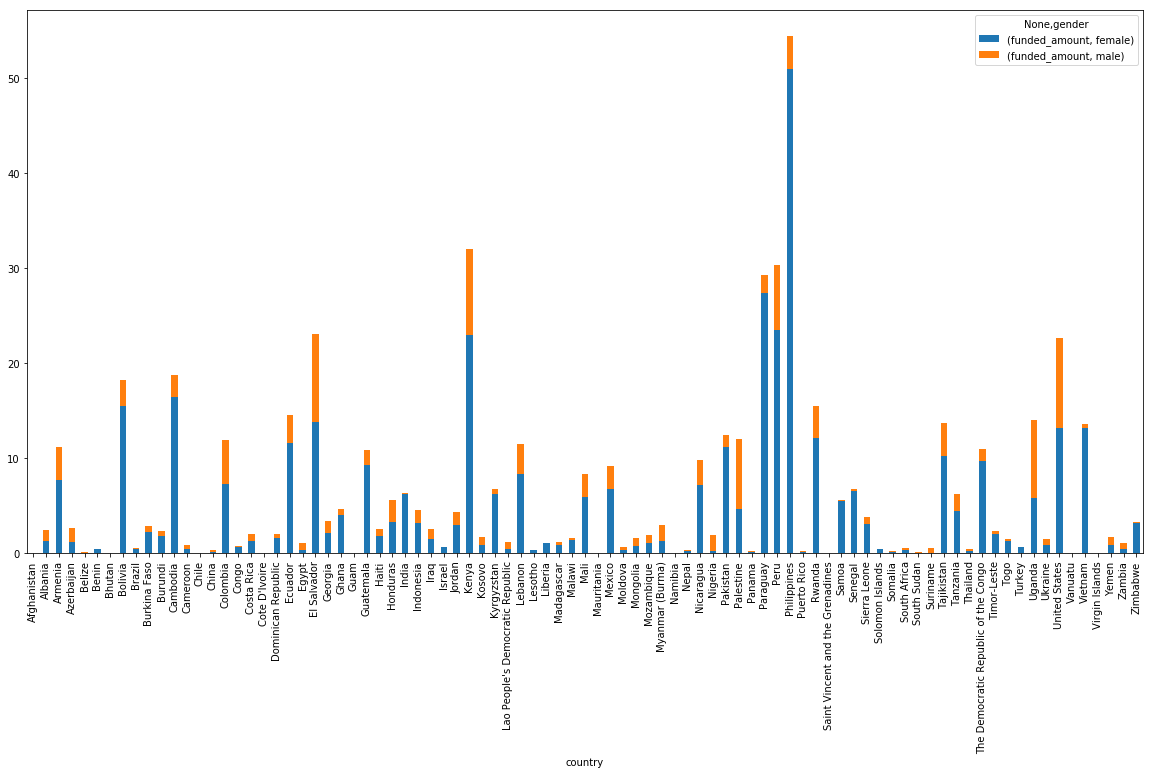

In [35]:
figure, ax = plt.subplots(figsize=(20,10))
(df.groupby(
       ['country', 'gender']
    )[['funded_amount']].sum() / (1000 * 1000 )).reset_index().pivot(
    index='country', columns='gender'
).plot.bar(
    stacked=True,
    ax=ax
)
plt.show()

In [36]:
## Median Loan Amount Ranking

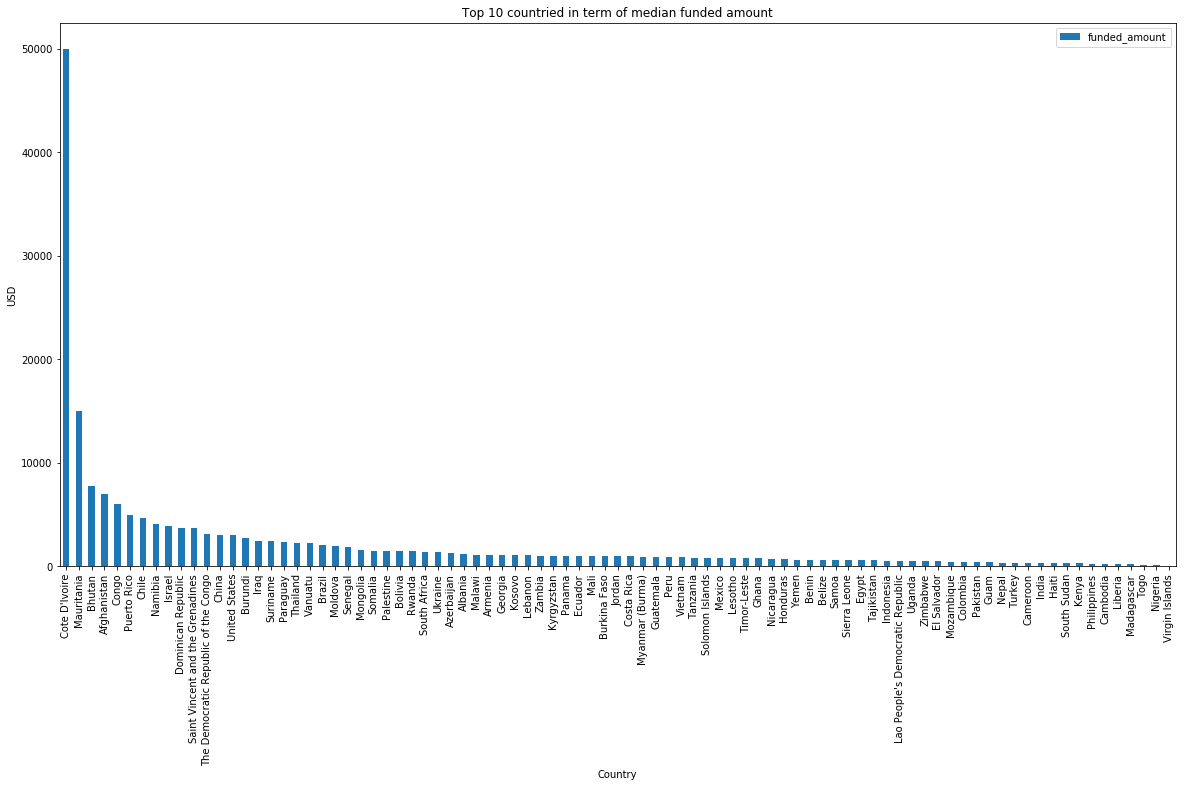

In [37]:
figure, ax = plt.subplots(figsize=(20,10))
( df.groupby('country')[['funded_amount']].median() ).sort_values(
    by='funded_amount', ascending=False).plot.bar(
    ax=ax,
)
plt.xlabel('Country')
plt.ylabel('USD')
plt.title('Top 10 countried in term of median funded amount')
plt.show()

## GDP vs Median Funded Amount

In [104]:
from narcos.kiva_data import KivaData

kiva_data = KivaData(use_sample=False)
median_by_country = df.groupby('country_code')[['funded_amount']].agg(['median', 'count'])
median_by_country

funded_amount       
                    median  count
country_code                     
AF                  7000.0      2
AL                  1175.0   1934
AM                  1150.0   8631
AZ                  1300.0   1945
BF                   975.0   2460
BI                  2737.5    880
BJ                   625.0    497
BO                  1450.0   8806
BR                  2100.0    284
BT                  7812.5      2
BZ                   625.0    125
CD                  3100.0   3073
CG                  6025.0    128
CI                 50000.0      1
CL                  4725.0     10
CM                   350.0   2230
CN                  3025.0    134
CO                   425.0  21995
CR                   975.0   1561
DO                  3725.0    496
EC                  1000.0  13521
EG                   575.0   1639
GE                  1125.0   2409
GH                   800.0   4374
GT                   925.0   7310
GU                   395.0      1
HN                   675.0   6557
HT                   325.0   3618
ID                   550.0   6214
IL                  3887.5    190
...                    ...    ...
PR                  5000.0     68
PS                  1500.0   8167
PY                  2400.0  11903
RW                  1450.0   6735
SB                   850.0    554
SL                   600.0   5415
SN                  1850.0   3269
SO                  1500.0     75
SR                  2450.0    223
SS                   312.5    160
SV                   500.0  39875
TG                   175.0   5749
TH                  2275.0    180
TJ                   575.0  19580
TL                   800.0   2690
TR                   375.0   1703
TZ                   850.0   5219
UA                  1350.0    963
UG                   525.0  20601
US                  3000.0   6093
VC                  3687.5     16
VI                     0.0      2
VN                   900.0  10843
VU                  2262.5      4
WS                   600.0   7396
XK                  1125.0   1419
YE                   625.0   2313
ZA                  1425.0    378
ZM                  1025.0    784
ZW                   500.0   4034

[86 rows x 2 columns]

In [106]:
gdp = kiva_data.gdp

In [107]:
gdp.loc[:,'gdp'] = pd.to_numeric(gdp['gdp'])

In [108]:
median_by_country = median_by_country.reset_index().merge(   
    gdp, on='country_code'
)

C:\Users\feng443\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [109]:
median_by_country.columns

Index([             'country_code',        ('country_code', ''),
       ('funded_amount', 'median'),  ('funded_amount', 'count'),
                             'gdp'],
      dtype='object')

In [116]:
median_by_country = median_by_country.rename(
    columns = {
        ('funded_amount', 'median'): 'median',
        ('funded_amount', 'count'): 'count',
    }
)

In [119]:
median_by_country.head()

,country_code,"(country_code, )",median,count,gdp
0,AF,AF,7000.0,2,561.778746
1,AL,AL,1175.0,1934,4124.982390
2,AM,AM,1150.0,8631,3614.688357
3,AZ,AZ,1300.0,1945,3878.709257
4,BF,BF,975.0,2460,627.103079


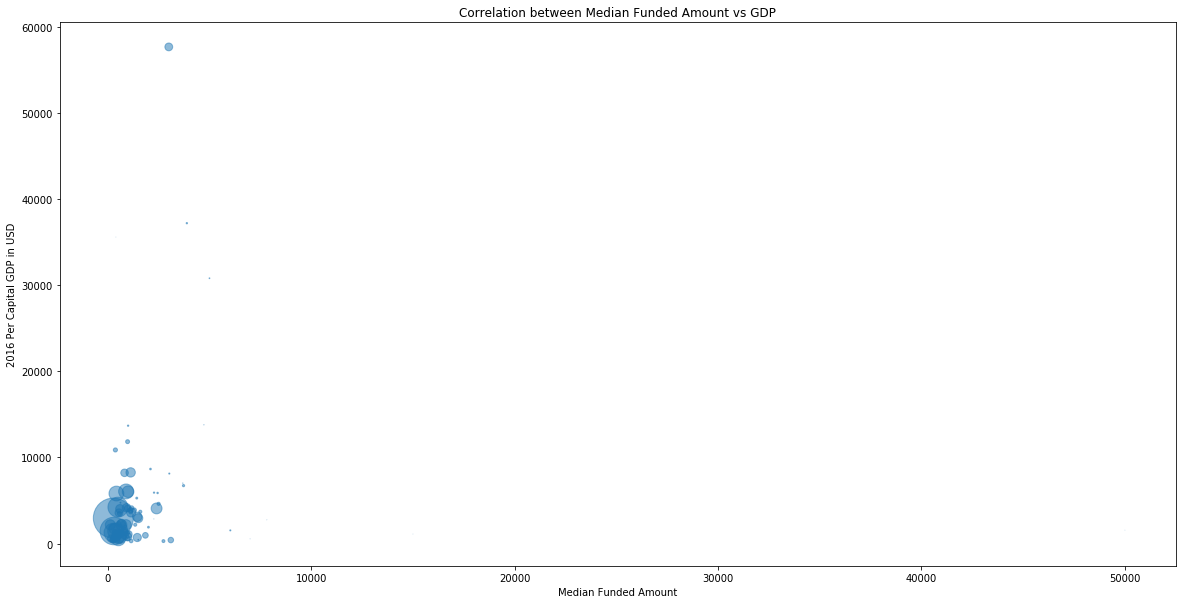

In [121]:
figure, ax = plt.subplots(figsize=(20,10))
ax.scatter(
    x=median_by_country['median'],
    y=median_by_country['gdp'],
    s=median_by_country['count']/100,
    alpha=0.5,
)

plt.xlabel('Median Funded Amount')
plt.ylabel('2016 Per Capital GDP in USD')
plt.title('Correlation between Median Funded Amount vs GDP')
plt.show()

### Narrow down to GDP < 20000, and Median Funded Amount < 4000

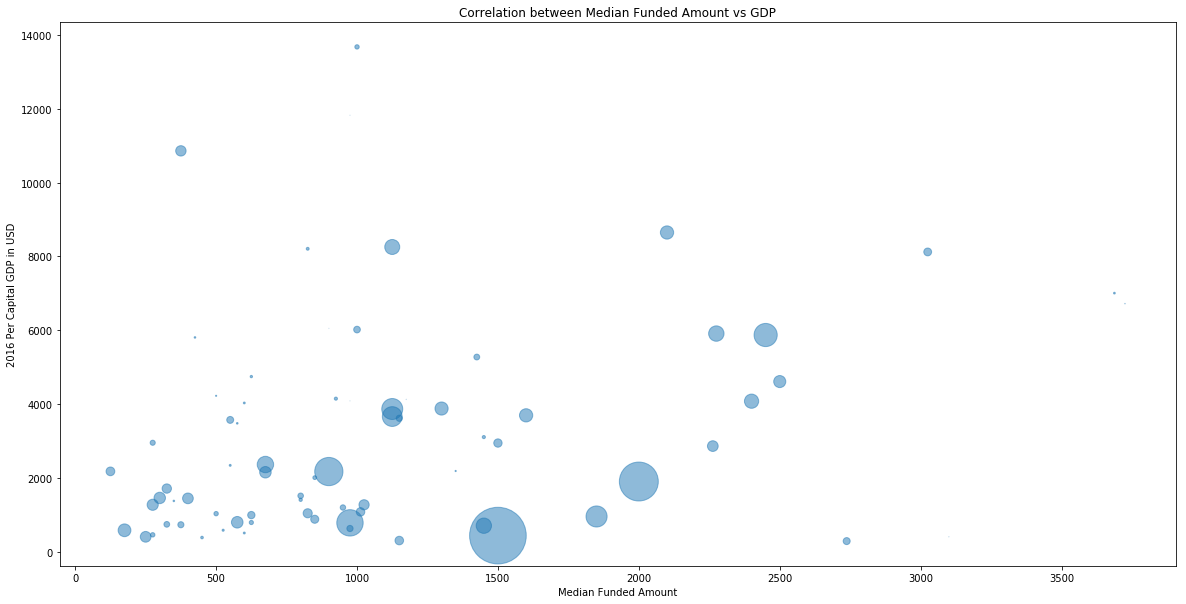

In [127]:
figure, ax = plt.subplots(figsize=(20,10))
median_by_country.query(
    'gdp < 20000 & median < 4000'
).plot.scatter(
    x='median',
    y = 'gdp',
    s = median_by_country['count']/50,
    ax=ax,
    alpha=0.5,
)

plt.xlabel('Median Funded Amount')
plt.ylabel('2016 Per Capital GDP in USD')
plt.title('Correlation between Median Funded Amount vs GDP')
plt.show()

## Gender

In [134]:
gdp[['country_code', 'gdp']].iterrows()

<generator object DataFrame.iterrows at 0x0000023A81E776D0>

In [147]:
gdp_lookup = {
    x[1]: x[2]
    for x in gdp[['country_code', 'gdp']].itertuples()
}

In [149]:
median_by_country = df.groupby(['country_code', 'gender'])[['funded_amount']].median().reset_index()

median_by_country.loc[:, 'gdp'] = median_by_country['country_code'].map(
    lambda x: pd.to_numeric(gdp_lookup.get(x, 0))
)

In [150]:
median_by_country = median_by_country.set_index(['country_code', 'gender'])


In [151]:
count_by_country = df.groupby(['country_code', 'gender'])[['funded_amount']].count().rename(
    columns={'funded_amount': 'loan_count'}
)
median_by_country = median_by_country.join(count_by_country).reset_index()

In [152]:
median_by_country.head()

,country_code,gender,funded_amount,gdp,loan_count
0,AF,female,7000.0,561.778746,2
1,AL,female,1175.0,4124.982390,1018
2,AL,male,1150.0,4124.982390,899
3,AM,female,1275.0,3614.688357,5383
4,AM,male,1000.0,3614.688357,3245


In [153]:
median_by_country[
    median_by_country['gender'] == 'male'
].head()

,country_code,gender,funded_amount,gdp,loan_count
2,AL,male,1150.0,4124.982390,899
4,AM,male,1000.0,3614.688357,3245
6,AZ,male,1150.0,3878.709257,1202
8,BF,male,875.0,627.103079,620
10,BI,male,2937.5,285.727442,188


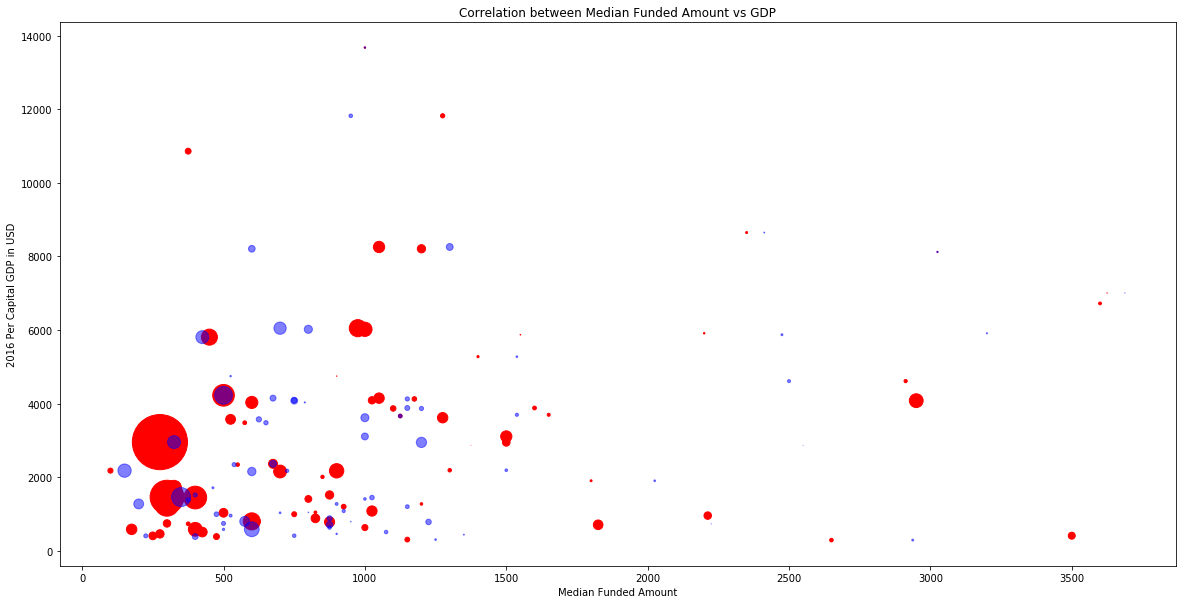

In [157]:
figure, ax = plt.subplots(figsize=(20,10))

median_by_country = median_by_country.query('gdp < 20000 & funded_amount < 4000')
female_df = median_by_country[
    median_by_country['gender'] == 'female'
]

female_df.plot.scatter(
    x='funded_amount',
    y='gdp',
    color='red',
    s = female_df['loan_count']/50,
    ax=ax
)

male_df = median_by_country[
    median_by_country['gender'] == 'male'
]

male_df.plot.scatter(
    x='funded_amount',
    y='gdp',
    color='blue',
    s = male_df['loan_count']/50,
    ax=ax,
    alpha=0.5
)

plt.xlabel('Median Funded Amount')
plt.ylabel('2016 Per Capital GDP in USD')
plt.title('Correlation between Median Funded Amount vs GDP')
plt.show()

### Narrow down to GDP < 20000, and Median Funded Amount < 4000

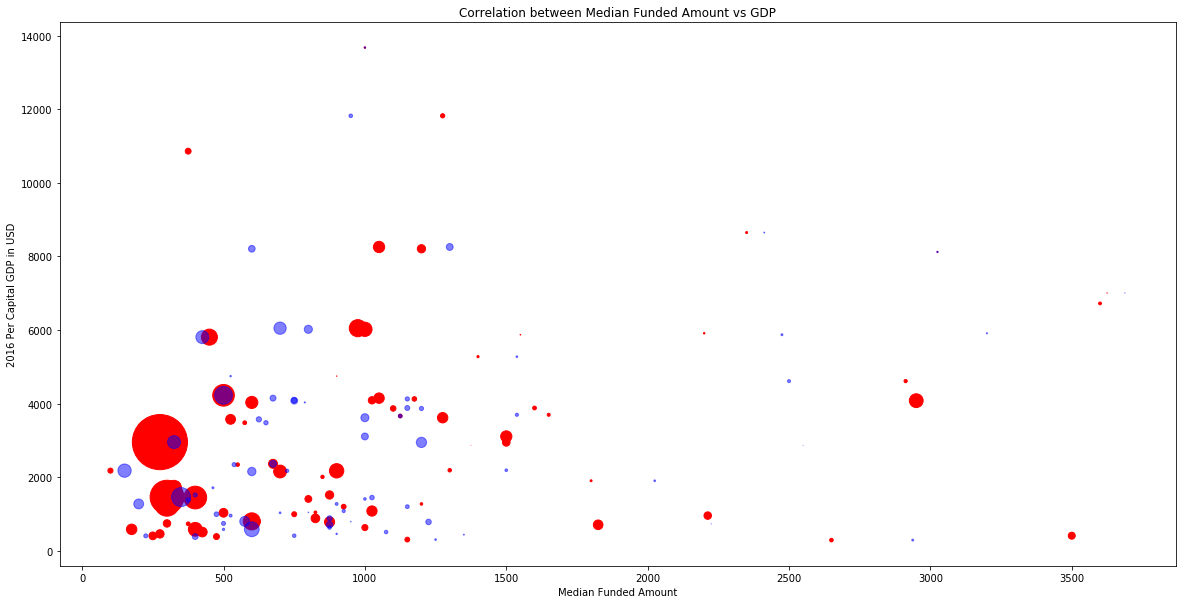

In [158]:
figure, ax = plt.subplots(figsize=(20,10))

female_df = median_by_country[
    median_by_country['gender'] == 'female'
]

female_df.plot.scatter(
    x='funded_amount',
    y='gdp',
    color='red',
    s = female_df['loan_count']/50,
    ax=ax
)

male_df = median_by_country[
    median_by_country['gender'] == 'male'
]

male_df.plot.scatter(
    x='funded_amount',
    y='gdp',
    color='blue',
    s = male_df['loan_count']/50,
    ax=ax,
    alpha=0.5
)

plt.xlabel('Median Funded Amount')
plt.ylabel('2016 Per Capital GDP in USD')
plt.title('Correlation between Median Funded Amount vs GDP')
plt.show()